In [25]:
import os
import mne
import pandas as pd
from mne_bids import BIDSPath

bids_root = os.path.join(mne.get_config('MNE_DATA'), 'derivatives', 'mne-bids-pipeline', 'STBF-ERP_CORE')
subject_paths = BIDSPath(root=bids_root, task='P3', datatype='eeg', processing='clean', suffix='epo', check=False)
subject_paths = subject_paths.match()

In [26]:
from decode.cov import FullCovariance, NonIterativeKroneckerCovariance
from sklearn.pipeline import Pipeline
from decode.stbf import LCMVBeamformer
from decode.classifier import UnitVarianceChannelScaler
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import numpy as np

stbf_struct = Pipeline([
    ('scaler', UnitVarianceChannelScaler()),
    ('bf', LCMVBeamformer(cov_estimator=NonIterativeKroneckerCovariance(shrinkage=('oas', 'oas')))),
])

stbf_shrunk = Pipeline([
    ('scaler', UnitVarianceChannelScaler()),
    ('bf', LCMVBeamformer(cov_estimator=FullCovariance(shrinkage='oas'))),
])

stbf_emp = Pipeline([
    ('scaler', UnitVarianceChannelScaler()),
    ('bf', LCMVBeamformer(cov_estimator=FullCovariance(shrinkage=False))),
])

xdawn_rg = Pipeline([
    ('scaler', UnitVarianceChannelScaler()),
    ('covariances', XdawnCovariances(nfilter=2, estimator='scm', xdawn_estimator='scm')),
    ('riemann', TangentSpace(metric="riemann")),
    ('nan_to_zero', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('logit', LogisticRegression(class_weight='balanced'))
])

In [27]:
from sklearn.model_selection import KFold

classifiers = {
    'STBF-struct': stbf_struct,
    'STBF-shrunk': stbf_shrunk,
    'STBF-emp': stbf_emp,
    'xDAWN+RG': xdawn_rg,
}
k = 5
cv = KFold(n_splits=k, shuffle=False)
scoring = ['roc_auc']
metrics = pd.DataFrame()

In [28]:
from sklearn.model_selection import cross_validate

for i, subject_path in enumerate(subject_paths):
    print(f"[{i+1}/{len(subject_paths)}] Subject {subject_path.subject} ...")
    epochs = mne.read_epochs(subject_path.fpath, verbose=0)
    epochs.pick_types(eeg=True, eog=True)
    epochs.drop_channels(['P9', 'P10'])
    epochs.crop(tmin=0.1, tmax=0.6)
    epochs.metadata['label'] = epochs.metadata['event_name'].str.startswith('stimulus/target')
    y = epochs.metadata['event_name'].str.startswith('stimulus/target').values.astype(int)
    X = epochs.get_data()
    for classifier_model, classifier in classifiers.items():
        metrics_arr = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        metrics_df = pd.DataFrame(metrics_arr)
        metrics_df['classifier'] = classifier_model
        metrics_df['subject'] = subject_path.subject
        metrics_df['fold'] = list(range(k))
        metrics = metrics.append(metrics_df, ignore_index=True)
metrics

[1/40] Subject 001 ...
[2/40] Subject 002 ...
[3/40] Subject 003 ...
[4/40] Subject 004 ...
[5/40] Subject 005 ...
[6/40] Subject 006 ...
[7/40] Subject 007 ...
[8/40] Subject 008 ...
[9/40] Subject 009 ...
[10/40] Subject 010 ...
[11/40] Subject 011 ...
[12/40] Subject 012 ...
[13/40] Subject 013 ...
[14/40] Subject 014 ...
[15/40] Subject 015 ...
[16/40] Subject 016 ...
[17/40] Subject 017 ...
[18/40] Subject 018 ...
[19/40] Subject 019 ...
[20/40] Subject 020 ...
[21/40] Subject 021 ...
[22/40] Subject 022 ...
[23/40] Subject 023 ...
[24/40] Subject 024 ...
[25/40] Subject 025 ...
[26/40] Subject 026 ...
[27/40] Subject 027 ...
[28/40] Subject 028 ...
[29/40] Subject 029 ...
[30/40] Subject 030 ...
[31/40] Subject 031 ...
[32/40] Subject 032 ...
[33/40] Subject 033 ...
[34/40] Subject 034 ...
[35/40] Subject 035 ...
[36/40] Subject 036 ...
[37/40] Subject 037 ...
[38/40] Subject 038 ...
[39/40] Subject 039 ...
[40/40] Subject 040 ...


,fit_time,score_time,test_roc_auc,classifier,subject,fold
0,0.046768,0.008053,0.468750,STBF-struct,001,0
1,0.027034,0.003024,0.691406,STBF-struct,001,1
2,0.062249,0.006063,0.851562,STBF-struct,001,2
3,0.040904,0.003840,0.695312,STBF-struct,001,3
4,0.038363,0.003844,0.710938,STBF-struct,001,4
...,...,...,...,...,...,...
795,0.211544,0.006901,0.433594,xDAWN+RG,040,0
796,0.170694,0.006490,0.722656,xDAWN+RG,040,1
797,0.158764,0.006393,0.699219,xDAWN+RG,040,2
798,0.150950,0.007182,0.558594,xDAWN+RG,040,3


<AxesSubplot:xlabel='classifier', ylabel='test_roc_auc'>

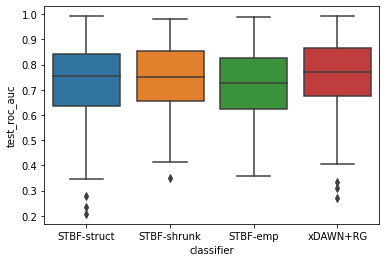

In [29]:
import seaborn as sns

sns.boxplot(data=metrics, x='classifier', y='test_roc_auc')

<AxesSubplot:xlabel='classifier', ylabel='fit_time'>

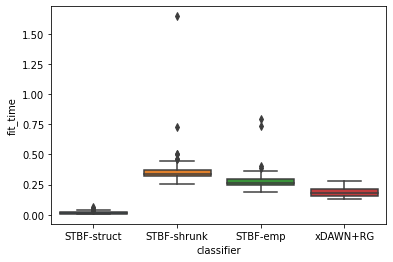

In [30]:
sns.boxplot(data=metrics, x='classifier', y='fit_time')